In [1]:
%%capture
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import calc_class_weights
from pyecg.data_info import *
from pyecg.data_handling import DataHandling
from pyecg.report import Reports
from pyecg.data_preprocessing import clean_inf_nan,clean_IQR
from pyecg.utils import sig_similarity_report,sig_similarity_hist
from pyecg.data_handling import slice_data
from pyecg.data_arrhythmia import *


reset_seed() 

2022-04-20 07:01:35.763928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 07:01:35.763954: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-20 07:01:37.401467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-20 07:01:37.401489: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 07:01:37.401506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mypc-zen): /proc/driver/nvidia/version does not exist
2022-04-20 07:01:37.401659: I tensorflow/core/platform/cpu_feature_g

# Proto

In [2]:
datasets = {1:'raw_arr'}
models = {1:'conv1d_arr'}

CONFIG = {}
CONFIG['dataset'] = datasets[1]
CONFIG['model'] = models[1]
CONFIG['model_type'] = 'CLF' #CLF or AE
CONFIG['augment'] = False 
CONFIG['sliced_targets'] = None #{'N':0} #None  #{'N':0,'A':1}
CONFIG['AAMI'] = False 
CONFIG['class_weight'] = False 
CONFIG['normalization'] = None      #'zscore' 'minmax' , None, 'max' 

# Data

In [3]:
#Load data
if CONFIG['dataset'] == 'raw_arr':
    annotated_records, samples_info = load_data(file_path = '../data/train.arr')

File loaded: ../data/train.arr


In [4]:
samples_info[0][2]-samples_info[0][1]  #win size

10800

In [5]:
labels=[]
for sample in samples_info:
    labels.append(sample[3])
len(labels)
np.unique(labels,return_counts=True)

(array(['(AB', '(AFIB', '(AFL', '(B', '(BII', '(N', '(SBR'], dtype='<U5'),
 array([   211,  26343,    736,   1438,   3093, 143157,   9986]))

In [6]:
cleaned = []
for sample in samples_info:
    if sample[3] in ['(AFIB','(N']:
        cleaned.append(sample)
samples_info = cleaned  
len(samples_info)

169500

In [7]:
labels=[]
for sample in samples_info:
    labels.append(sample[3])
len(labels)

169500

In [8]:
class_labels = list(np.unique(labels))
class_labels

['(AFIB', '(N']

In [9]:
len(annotated_records[0]['signal']) #signal length

650000

In [10]:
labels=[]
s=[]
c=0
for sample in samples_info:
    c += 1
    if sample[3] == '(N' and bool(c%5): #20
        continue
    labels.append(sample[3])
    s.append(sample)
len(s)
samples_info = s

In [11]:
np.unique(labels,return_counts=True)

(array(['(AFIB', '(N'], dtype='<U5'), array([26343, 28631]))

# Train

In [12]:
if CONFIG['model'] == 'conv1d_arr':
    from pyecg.models.conv1d_arr import model_arch

In [13]:
params_model = {
    'x_input_dim' : samples_info[0][2]-samples_info[0][1],  #win size
    'num_classes' : len(np.unique(labels)),
    'regularizer' : None
}
params_train = {
    'batch_size' : 256,
    'epochs' : 1
} 

In [14]:
mymodel = model_arch(params_model)                                          


Layer: BATCH_NORMALIZATION/BATCHNORM/ADD_1:0 -->  Output shape: [None, 9, 1]

Layer: DROPOUT/IDENTITY:0 -->  Output shape: [None, 2048]

Layer: DROPOUT_1/IDENTITY:0 -->  Output shape: [None, 512]

Layer: DENSE_2/RELU:0 -->  Output shape: [None, 256]

Layer: DENSE_3/SOFTMAX:0 -->  Output shape: [None, 2]


In [15]:
mymodel.summary()

Model: "Model_Conv1d_ARR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rri_feats (InputLayer)   [(None, 9)]          0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 9, 1)         0           ['input_rri_feats[0][0]']        
                                                                                                  
 batch_normalization (BatchNorm  (None, 9, 1)        4           ['tf.expand_dims[0][0]']         
 alization)                                                                                       
                                                                                                  
 flatten (Flatten)              (None, 9)            0           ['batch_normalizat

In [16]:
#%%capture
#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss

In [17]:
def my_log_loss(y_true, y_pred):
    squared_difference = tf.square(tf.math.log(y_true + 5) - tf.math.log(y_pred + 5))
    return tf.reduce_mean(squared_difference, axis=-1) 

In [18]:
!rm -r /media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1

opt= tf.keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

def get_loss(model_type):
    if model_type == 'AE':
        loss = "mse"
        #loss = 'binary_crossentropy'
        #loss='mean_squared_logarithmic_error'
        #loss = my_log_loss
        #loss = 'cosine_similarity'
    else:
        loss = "sparse_categorical_crossentropy"
        #loss=SparseCategoricalFocalLoss(gamma=3)
    return loss

def get_metrics(model_type):
    if model_type == 'AE':
        metrics = None
    else:
        metrics = ['accuracy']
    return metrics
    

mymodel.compile(
              optimizer = opt,
              loss = get_loss(CONFIG['model_type']),
              metrics = get_metrics(CONFIG['model_type']),
              loss_weights = None,
              run_eagerly = False
              )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.EXP1",
                                                      monitor='val_loss', save_best_only=True, verbose=1)
import time
batch_sleep = tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch,logs: time.sleep(0.5))

callbacks = [early_stopping, model_checkpoint, reduce_lr, batch_sleep]  
callbacks = [batch_sleep]  

rm: cannot remove '/media/mypc/STORAGE1/codes/heartbeat/checkpoint/keras.EXP1': No such file or directory


In [19]:
class_labels

['(AFIB', '(N']

In [20]:
train_generator = ECGSequence(annotated_records, samples_info, class_labels,
                              batch_size=params_train['batch_size'])

In [21]:
train_generator.__getitem__(0)[0][2][9]

array([1.1381945e+03, 1.4752034e+02, 1.1555555e+03, 5.3333331e+02,
       1.2960908e-01, 1.0624803e+02, 1.0662166e+02, 9.3676135e-02,
       1.0000000e+02], dtype=float32)

In [49]:
%%time

#model fitting
model_history = mymodel.fit_generator(generator=train_generator,
                                    #validation_data=validation_generator,
                                    use_multiprocessing=True,
                                    #workers=2,
                                    epochs=params_train['epochs'],
                                    verbose=1,
                                    callbacks=callbacks
                                     )


<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


215/215 [==============================] - 127s 587ms/step - loss: 0.1754 - accuracy: 0.9268
CPU times: user 2min 4s, sys: 42.2 s, total: 2min 46s
Wall time: 2min 7s


In [50]:
#plot_loss(model_history) 

import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)

a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

# Loading Model

In [51]:
#loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.EXP1')
#mymodel = tf.keras.models.load_model(BASEPATH+'saved_models/mymodel.af')
loaded_model = mymodel
loaded_model.name 
#loaded_model.summary() 

'Model_Conv1d_ARR'

In [60]:
#Load Test Set
#Load data
if CONFIG['dataset'] == 'raw_arr': 
    annotated_records_test, samples_info_test = load_data(file_path = '../data/test.arr')

File loaded: ../data/test.arr


In [61]:
len(samples_info_test)

2139

In [62]:
cleaned = []
for sample in samples_info_test:
    if sample[3] in class_labels:
        cleaned.append(sample)
samples_info_test = cleaned  
len(samples_info_test)

2056

In [63]:
labels=[]
for sample in samples_info_test:
    labels.append(sample[3])
len(labels)

np.unique(labels,return_counts=True)

(array(['(AFIB', '(N'], dtype='<U5'), array([  98, 1958]))

In [64]:
labels=[]
for sample in samples_info_test:
    labels.append(sample[3])
len(labels)

np.unique(labels,return_counts=True)

(array(['(AFIB', '(N'], dtype='<U5'), array([  98, 1958]))

In [65]:
batch_size=128
test_generator = ECGSequence(annotated_records_test, samples_info_test, class_labels,
                              batch_size=batch_size) 

In [66]:
labels_true=[]
labels_pred = []
all_samples = []
for i in range(round(len(samples_info_test)/batch_size)): 
    samples = test_generator.__getitem__(i)
    
    labels_true.extend(samples[1])
    probs = loaded_model.predict_generator(samples[0])
    labels_pred.extend(list(np.argmax(probs,axis=1)))
    
    all_samples.extend((samples[0][0]).tolist())
assert len(labels_true) == len(labels_pred)

/tmp/ipykernel_11175/4183120069.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probs = loaded_model.predict_generator(samples[0])


In [67]:
if CONFIG['model_type'] == 'CLF':
    from sklearn.metrics import confusion_matrix, classification_report
    print(classification_report(labels_true, labels_pred))
    print(confusion_matrix(labels_true, labels_pred)) 

              precision    recall  f1-score   support

           0       0.27      0.83      0.41        98
           1       0.99      0.89      0.94      1950

    accuracy                           0.88      2048
   macro avg       0.63      0.86      0.67      2048
weighted avg       0.96      0.88      0.91      2048

[[  81   17]
 [ 220 1730]]


In [33]:
#check which? ectopic

In [34]:
ix_pred0 = np.where(np.array(labels_pred)==0)[0]
ix_tru0 = np.where(np.array(labels_true)==0)[0]

In [35]:
ix_tru0

array([  19,   36,   41,   45,   50,  104,  107,  116,  148,  149,  157,
        185,  250,  261,  265,  319,  331,  357,  367,  402,  428,  429,
        441,  485,  523,  617,  643,  711,  714,  716,  720,  733,  754,
        756,  791,  800,  802,  838,  881,  892,  894,  906,  915,  929,
        937,  972,  978,  980, 1002, 1014, 1022, 1047, 1055, 1069, 1072,
       1109, 1121, 1128, 1132, 1142, 1152, 1159, 1264, 1294, 1319, 1354,
       1363, 1388, 1396, 1410, 1443, 1464, 1479, 1485, 1508, 1524, 1527,
       1558, 1562, 1642, 1659, 1671, 1684, 1699, 1705, 1712, 1732, 1739,
       1751, 1804, 1805, 1822, 1827, 1839, 1854, 1857, 1875, 1905])

In [36]:
len(ix_pred0),len(ix_tru0)

(280, 98)

In [37]:
dif = list(set(ix_pred0)-set(ix_tru0))
len(dif)

185

In [38]:
dif

[1537,
 8,
 524,
 525,
 529,
 535,
 26,
 1053,
 541,
 1054,
 34,
 549,
 40,
 554,
 46,
 1582,
 53,
 55,
 1081,
 61,
 1602,
 579,
 581,
 70,
 1095,
 73,
 586,
 1099,
 76,
 591,
 1104,
 85,
 599,
 603,
 95,
 1631,
 99,
 613,
 1637,
 1127,
 616,
 1646,
 628,
 1143,
 1656,
 633,
 128,
 1665,
 642,
 131,
 132,
 133,
 644,
 648,
 1162,
 1165,
 1171,
 1181,
 1696,
 674,
 1186,
 1190,
 1710,
 175,
 1714,
 1203,
 180,
 693,
 695,
 188,
 1728,
 705,
 1729,
 195,
 708,
 198,
 710,
 1738,
 1740,
 207,
 1743,
 1744,
 1748,
 214,
 219,
 1759,
 226,
 227,
 1252,
 1764,
 231,
 232,
 234,
 1260,
 238,
 1774,
 1775,
 755,
 1274,
 1787,
 252,
 260,
 777,
 778,
 1289,
 782,
 786,
 1811,
 1303,
 1817,
 290,
 1314,
 295,
 1321,
 1834,
 1323,
 1836,
 302,
 303,
 815,
 1841,
 1335,
 314,
 321,
 835,
 1863,
 330,
 1361,
 851,
 340,
 344,
 1369,
 1371,
 352,
 864,
 1380,
 869,
 359,
 372,
 1911,
 1401,
 1404,
 1918,
 384,
 1920,
 899,
 900,
 1413,
 1926,
 1431,
 921,
 415,
 1441,
 420,
 934,
 1959,
 426,
 1450,

In [39]:
len(all_samples)

2048

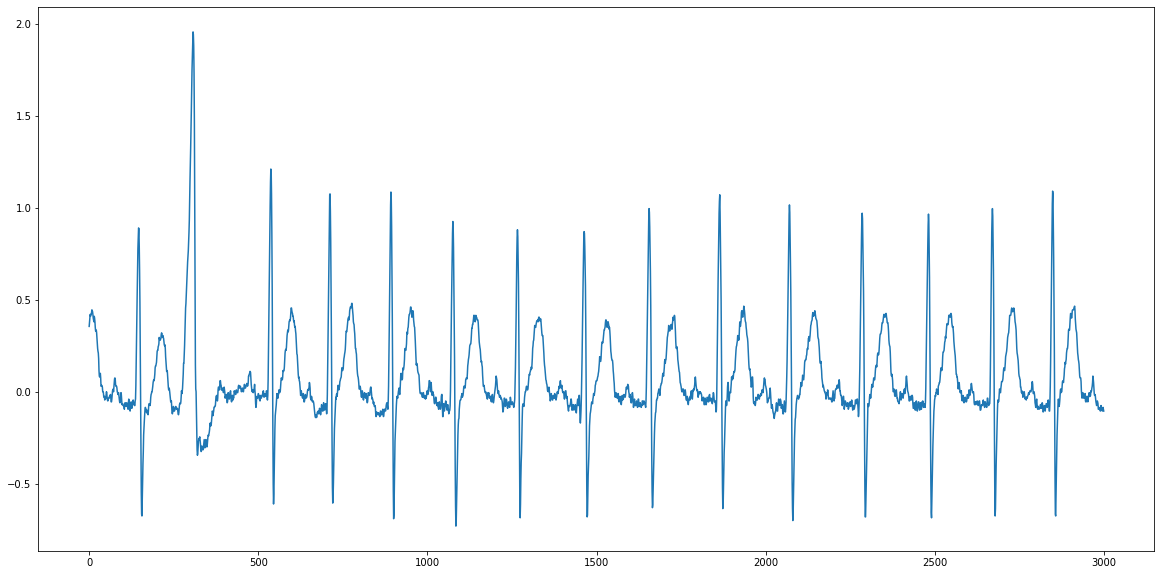

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(all_samples[823][:3000])